In [2]:
##################################################################################
#                        Anti-Correlation Region Analysis                        #
#  A code to analyze SAM correlation plots produced in Matlab using an OpenCV AI #
#      to identify anti-correlation regions, and find their centers & areas      #
#                              Author: Steven Doran                              #
##################################################################################

# import OpenCV packages
import cv2 as cv
import numpy as np

path1 = '[0]_[100]/Negative_Plots/ASIC_'
path2 = '_neg[0][100]_t100_150.png'

ACR = []   # Anti-correlation region array
for i in range(0,3):
    ACR.append([])
for i in range(len(ACR)):
    for j in range(0,100):
        ACR[i].append([])
        
# ACR[0] = x coordinate of center position
# ACR[1] = y coordinare of center position
# ACR[2] = area of contour

def ACR_finder(ChipIndex):

    # Crop image so that we are only focused on the central plot region
    img = cv.imread(path1 + str(ChipIndex+20) + path2)
    # img['top':'bottom', 'left:right'] -- x and y flipped (y, x)
    crop_img = img[118:1391, 203:1365]
    cv.imwrite("junk.png",crop_img)

    image = cv.imread("junk.png")
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # Noise reduction, negative color filtering, and image thresholding
    blur = cv.GaussianBlur(gray, (5, 5),
                           cv.BORDER_DEFAULT)
    ret, thresh = cv.threshold(blur, 200, 255,
                               cv.THRESH_BINARY_INV)

    # create negative
    cv.imwrite("thresh_junk.png", thresh)

    # Contour finding
    contours, hierarchies = cv.findContours(
        thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    blank = np.zeros(thresh.shape[:2],
                     dtype='uint8')

    # draw the contours and produce image
    cv.drawContours(blank, contours, -1,
                    (255, 0, 0), 1)

    cv.imwrite("Contours_junk.png", blank)
    
    # Dimensionalize the array
    for i in range(len(contours)):
        ACR[0][ChipIndex].append([])
        ACR[1][ChipIndex].append([])
        ACR[2][ChipIndex].append([])
        
    a = []
    # Finding centers via a moments calculation
    for i in range(len(contours)):
        M = cv.moments(contours[i])
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            cv.drawContours(image, [contours[i]], -1, (0, 255, 0), 2)
            cv.circle(image, (cx, cy), 7, (0, 0, 255), -1)
            cv.putText(image, "center", (cx - 20, cy - 20),
                       cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            
        # Append data to arrays
        ACR[0][ChipIndex][i].append(cx)
        ACR[1][ChipIndex][i].append(cy)
        ACR[2][ChipIndex][i].append(cv.contourArea(contours[i]))
        
    # Produce contours with centerpoints
    image_path = 'AI Contours/ASIC_' + str(ChipIndex+20) + '_contour.png'
    cv.imwrite(image_path, image)
    
    return

# Perform task for all ASICs
from tqdm.notebook import trange, tqdm
for i in trange(20,120):
    ASIC_N = i
    CI = ASIC_N - 20
    ACR_finder(CI)
    
print('\ndone')

  0%|          | 0/100 [00:00<?, ?it/s]


done


### We want two things:

Firstly, a histogram of the distance from a specified pin to see if the distances correlate. For this require the
x and y points of the ACRs, then calculate the distance between them and the specified pin points.

Secondly, using the ACR x and y coordinates, plot the ACR centers on an ASIC diagram to see where the points
are congregated.

### Remove 'noise' - Data subtraction

In [2]:
import matplotlib.pyplot as plt
import numpy as np

X_pos = []; Y_pos = []; Area_XY = []

'''First, remove ASICs with poor scans to limit number of ACRs'''

for i in range(len(ACR[0])):
    for j in range(len(ACR[0][i])):
        for k in range(len(ACR[0][i][j])):
            if i not in [57, 61, 63, 90, 96]:
                X_pos.append(ACR[0][i][j][0])
                Y_pos.append(ACR[1][i][j][0])
                Area_XY.append(ACR[2][i][j][0])
                
'''Next, remove the circles, which cause scattering and create ACRs that are not likely physically real'''

x_position = []; y_position = []; Area = []   # These become the new, low-noise arrays
for i in range(len(X_pos)):
    x_position.append(X_pos[i])
    y_position.append(Y_pos[i])
    Area.append(Area_XY[i])

for i in range(len(x_position) - 1, -1, -1):  # when we remove elements, it changes the length of our array
    if x_position[i] > 900 and y_position[i] > 1000:   # Big, lower circle
        del x_position[i]; del y_position[i]; del Area[i]
for i in range(len(x_position) - 1, -1, -1):  # therefor we loop backwards through the array instead of forwards
    if x_position[i] < 160 and y_position[i] < 160:   # small, upper circle
        del x_position[i]; del y_position[i]; del Area[i]
        
# We can be more selective with regions we are removing. This is a simple cut of the data based off
# of where we are most likely to find the noisy points


# We can also apply a cut to remove the 'central' NaN regions and the residual structure ACRs (lines)
'''Lastly, remove the inner region (NaN caused effects) and the residual structure lines'''

for i in range(len(x_position) - 1, -1, -1):  # when we remove elements, it changes the length of our array
    if 122 < x_position[i] < 1040 and 134 < y_position[i] < 1140:
        del x_position[i]; del y_position[i]; del Area[i]

print('done')

done


### Sort based off of Failure Mode

In [3]:
X_Dead = []; X_Single = []; X_Wave = []; X_else = []
Y_Dead = []; Y_Single = []; Y_Wave = []; Y_else = []
for i in range(len(ACR[0])):
    for j in range(len(ACR[0][i])):
        for k in range(len(ACR[0][i][j])):
            if i not in [57, 61, 63, 90, 96]:  # remove poor data ASICs
                if i in [7, 21, 55, 60, 68, 98]:   # Dead ASICs
                    X_Dead.append(ACR[0][i][j][0])
                    Y_Dead.append(ACR[1][i][j][0])
                elif i in [0, 32, 33, 43, 50, 51, 68, 79, 88, 98]:  # Faulty Waveform
                    X_Wave.append(ACR[0][i][j][0])
                    Y_Wave.append(ACR[1][i][j][0])
                elif i in [29, 33, 48, 54, 66, 75, 81, 91, 94]:  # Single channel failures
                    X_Single.append(ACR[0][i][j][0])
                    Y_Single.append(ACR[1][i][j][0])
                else:
                    X_else.append(ACR[0][i][j][0])
                    Y_else.append(ACR[1][i][j][0])
                    
###############################################################

# Need to remove the 'noisy' circle regions

data_x = [X_Dead, X_Single, X_Wave, X_else]
data_y = [Y_Dead, Y_Single, Y_Wave, Y_else]

for d in range(len(data_x)):
    for i in range(len(data_x[d]) - 1, -1, -1):
        if data_x[d][i] > 900 and data_y[d][i] > 1000:   # Big, lower circle
            del data_x[d][i]; del data_y[d][i]
    for i in range(len(data_x[d]) - 1, -1, -1):  # therefor we loop backwards through the array instead of forwards
        if data_x[d][i] < 160 and data_y[d][i] < 160:   # small, upper circle
            del data_x[d][i]; del data_y[d][i]
            
# Remove central region (NaN pixels) and the residual lines of structure
for d in range(len(data_x)):
    for i in range(len(data_x[d]) - 1, -1, -1):
        if 122 < data_x[d][i] < 1040 and 134 < data_y[d][i] < 1140:
            del data_x[d][i]; del data_y[d][i]
            

###############################################################

print('done')

done


In [4]:
# Build data arrays

D = [[] for i in range(0,5)]   # [all, single, dead, wave, else]
data_list_x = [x_position, X_Dead, X_Single, X_Wave, X_else]
data_list_y = [y_position, Y_Dead, Y_Single, Y_Wave, Y_else]
            

print('\ndone')


done


### Construct Scatterplot with ACRs overlaid on accurate ASIC figure

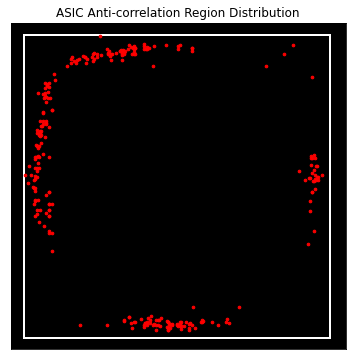

done


In [6]:
#%matplotlib

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6,6))
plt.xlim([-50,1220]); plt.ylim([1320,-50])

import matplotlib.patches as mpatches
left, bottom, width, height = (0, 0, 1162, 1273)  # Accurate dimensions of ASIC
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="white",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)
plt.scatter(data_list_x[0],data_list_y[0], s = 7, color = 'red')
plt.title('ASIC Anti-correlation Region Distribution')
plt.xticks([]); plt.yticks([])
ax.set_facecolor("black")
plt.savefig('ASIC ACR Distrbution.png',dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'white')

plt.show()

print('done')

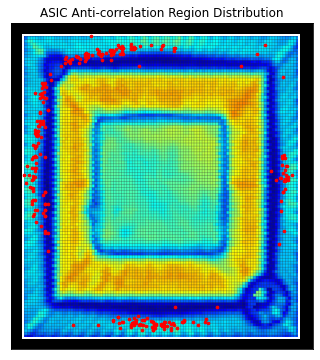

done


In [13]:
# Produce the same ACR plot, but you can overlay (in the background) an image of an amplitude plot

fig, ax = plt.subplots(figsize=(6,6))
plt.xlim([-50,1220]); plt.ylim([1320,-50])

import matplotlib.patches as mpatches
left, bottom, width, height = (0, 0, 1162, 1273)  # Accurate dimensions of ASIC
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="white",
                       linewidth=2)
                       #facecolor="red")

# Overlay image of SAM amplitude plot
im0 = plt.imread('ASIC_92_AmpCC0_[0][100]_t100_149.png')
crop_img = im0[118:1391, 203:1365]
implot0 = plt.imshow(crop_img)
    
plt.gca().add_patch(rect)
plt.scatter(data_list_x[0],data_list_y[0], s = 7, color = 'red')
plt.title('ASIC Anti-correlation Region Distribution')
plt.xticks([]); plt.yticks([])
ax.set_facecolor("black")
plt.savefig('../../../ASIC ACR Distrbution with Amp Plot.png',dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'white')

plt.show()

print('done')

In [6]:
print('Number of ACRs =', len(data_list_x[0]))
print('\n')
print('Normalized Number of ACRs (ACR/chip):')
print('Nominal =', round(len(data_list_x[4])/73,2))
print('Dead =', round(len(data_list_x[1])/6,2))
print('Single =', round(len(data_list_x[2])/9,2))
print('Wave =', round(len(data_list_x[3])/10,2))
print('Total =', round(len(data_list_x[0])/95,2))

Number of ACRs = 284


Normalized Number of ACRs (ACR/chip):
Nominal = 2.73
Dead = 5.0
Single = 3.11
Wave = 2.7
Total = 2.99


### Distribution of the number of ACRs based off of failure type (faulty vs nominal)

In [9]:
# We want to count the number of ACRs for each ASIC, then plot the distribution of ACRs/ASIC for faulty vs nominal ASICs
# Above, we sorted the arrays not based on individual ASICs, but rather these ASICs are faulty, so we put all of them in one array
# Essentially, we will do the same but dimensionalize the arrays so that they are sorted on an ASIC by ASIC basis

# many of these indicies will be blank. I have them 100 in length so that I can loop through them in the for loop below
All_Faulty_x = [[] for i in range(0,100)]; Normal_x = [[] for i in range(0,100)]
All_Faulty_y = [[] for i in range(0,100)]; Normal_y = [[] for i in range(0,100)]
# Area
All_Faulty_area = [[] for i in range(0,100)]; Normal_area = [[] for i in range(0,100)]
# We technically only need the lengths (count) of the arrays, however to sort out the noise we need both the x and y coords

for i in range(len(ACR[0])): # loop through 100 ASICs
    for j in range(len(ACR[0][i])):  # loop through each ACR
        if i not in [57, 61, 63, 90, 96]:  # remove poor data ASICs
            # total of 15 ASICs that at some point displayed a function failure
            if i in [7, 21, 29, 33, 48, 50, 54, 55, 60, 68, 75, 88, 91, 94, 98]:
                All_Faulty_x[i].append(ACR[0][i][j][0])
                All_Faulty_y[i].append(ACR[1][i][j][0])
                All_Faulty_area[i].append(ACR[2][i][j][0])
            else:
                Normal_x[i].append(ACR[0][i][j][0])
                Normal_y[i].append(ACR[1][i][j][0])
                Normal_area[i].append(ACR[2][i][j][0])
                
                    
###############################################################

# Need to remove the 'noisy' circle regions

ddd_x = [All_Faulty_x, Normal_x]
ddd_y = [All_Faulty_y, Normal_y]
ddd_area = [All_Faulty_area, Normal_area]

for d in range(len(ddd_x)):
    for j in range(len(ddd_x[d])):
        for i in range(len(ddd_x[d][j]) - 1, -1, -1):
            if ddd_x[d][j][i] > 900 and ddd_y[d][j][i] > 1000:   # Big, lower circle
                del ddd_x[d][j][i]; del ddd_y[d][j][i]; del ddd_area[d][j][i]
        for i in range(len(ddd_x[d][j]) - 1, -1, -1):  # therefore we loop backwards through the array instead of forwards
            if ddd_x[d][j][i] < 160 and ddd_y[d][j][i] < 160:   # small, upper circle
                del ddd_x[d][j][i]; del ddd_y[d][j][i]; del ddd_area[d][j][i]
            
# Remove central region (NaN pixels) and the residual lines of structure
for d in range(len(ddd_x)):
    for j in range(len(ddd_x[d])):
        for i in range(len(ddd_x[d][j]) - 1, -1, -1):
            if 122 < ddd_x[d][j][i] < 1040 and 134 < ddd_y[d][j][i] < 1140:
                del ddd_x[d][j][i]; del ddd_y[d][j][i]; del ddd_area[d][j][i]
            
###############################################################
# add 'blank' to the arrays with non-relevant blank entries.
# this way, we can differentiate between ASICs with zero ACRs (but belong to that type) and arrays
# that are empty simply because they do not belong to that group
for i in range(len(ddd_x)):
    for j in range(len(ddd_x[i])):
        if j in [57, 61, 63, 90, 96]:
            ddd_x[i][j].append('blank'); ddd_area[i][j].append('blank')

for j in range(len(ddd_x[1])):   
    if j in [7, 21, 29, 33, 48, 50, 54, 55, 60, 68, 75, 88, 91, 94, 98]:
        ddd_x[1][j].append('blank'); ddd_area[1][j].append('blank')
for j in range(len(ddd_x[0])):
    if j not in [7, 21, 29, 33, 48, 50, 54, 55, 60, 68, 75, 88, 91, 94, 98]:
        ddd_x[0][j].append('blank'); ddd_area[0][j].append('blank')

# # # # # # #
print('done')

done


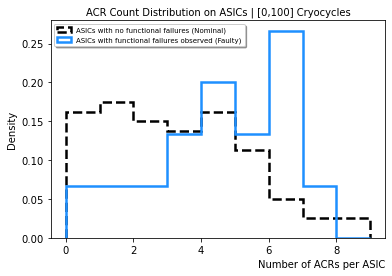

Number of ACRs in good chips =  222
Number of ACRs in bad chips =  62 

Good 0 27.735009811261456 %
Good 1 26.72612419124244 %
Good 2 28.86751345948129 %
Good 3 30.15113445777636 %
Good 4 27.735009811261456 %
Good 5 33.33333333333333 %
Good 6 50.0 %
Good 7 70.71067811865474 %
Good 8 70.71067811865474 %
Bad  0 100.0 %
Bad  1 100.0 %
Bad  2 100.0 %
Bad  3 70.71067811865474 %
Bad  4 57.73502691896258 %
Bad  5 70.71067811865474 %
Bad  6 50.0 %
Bad  7 100.0 %


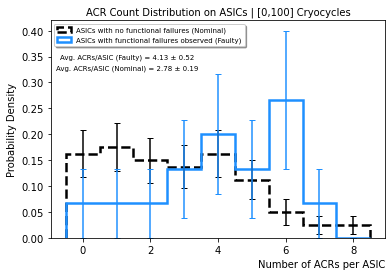

done


In [10]:
# ddd_x[0] = Faulty
# ddd_x[1] = Normal
# same for ddd_area

# these will be the histogram bulk arrays for plotting
bad = []; good = []; bad_area = []; good_area = []
for i in range(len(ddd_x[0])):   # loop through all ASICs
    if len(ddd_x[0][i]) == 0: 
        bad.append(len(ddd_x[0][i]))
        bad_area.append(sum(ddd_area[0][i]))   # sum up the areas of the ACRs
    else:
        if ddd_x[0][i][0] != 'blank':
            bad.append(len(ddd_x[0][i]))
            bad_area.append(sum(ddd_area[0][i]))
for i in range(len(ddd_x[1])):   # loop through all ASICs
    if len(ddd_x[1][i]) == 0: 
        good.append(len(ddd_x[1][i]))
        good_area.append(sum(ddd_area[1][i]))
    else:
        if ddd_x[1][i][0] != 'blank':
            good.append(len(ddd_x[1][i]))
            good_area.append(sum(ddd_area[1][i]))


# ACR Count per ASIC
fig, ax = plt.subplots()
ax.set_title('ACR Count Distribution on ASICs | [0,100] Cryocycles',fontdict = {'fontsize' : 10})
ax.set_xlabel('Number of ACRs per ASIC', loc = 'right')
ax.set_ylabel('Density')

# Plot Histograms
# maximum number of ACRs observed is 8 - make the bins integer-spaced
ax.hist(good, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], label = 'ASICs with no functional failures (Nominal)', 
        histtype = 'step', linestyle = 'dashed', stacked = False, density = True, color = 'black', linewidth = 2.5)
ax.hist(bad, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], label = 'ASICs with functional failures observed (Faulty)', 
        histtype = 'step', stacked = False, density = True, color = 'dodgerblue', linewidth = 2.5)

plt.legend(shadow=True, loc = 'upper left', prop={'size': 7})
path = '../../../../ACR Count Distribution for ASICs.png'
#plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')

plt.show()


#################################
'''
#######
# Total Area per ASIC
fig, ax = plt.subplots()
ax.set_title('ACR Area Distribution on ASICs | [0,100] Cryocycles',fontdict = {'fontsize' : 10})
ax.set_xlabel('Total ACR area per ASIC [arbitrary units]', loc = 'right')
ax.set_ylabel('Density')

# Plot Histograms
a = max(good_area) - min(good_area); b = max(bad_area) - min(bad_area); c = a/b
good_bins = 8; bad_bins = int(good_bins*c)
ax.hist(good_area, bins=good_bins, label = 'ASICs with no functional failures observed (Nominal)', 
        histtype = 'step', stacked = False, density = True, color = 'darkred', linewidth = 2.5)
ax.hist(bad_area, bins=bad_bins, label = 'ASICs with functional failures observed (Faulty)', 
        histtype = 'step', stacked = False, density = True, color = 'navy', linewidth = 2.5)

plt.legend(shadow=True, loc = 'upper right', prop={'size': 7})
path = '../../../../ACR area Distribution for ASICs.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')

plt.show()
'''

##################################
# With Errors

# To add errorbars, we need to overlay histogram with plt.errorbar
good_count = 0; bad_count = 0
x = [0,1,2,3,4,5,6,7,8]; y_good = []; y_bad = []
for i in range(0,9):
    y_good.append(good.count(i))
    good_count = good_count + y_good[i]*i
    y_bad.append(bad.count(i))
    bad_count = bad_count + y_bad[i]*i
    
print('Number of ACRs in good chips = ', good_count)
print('Number of ACRs in bad chips = ', bad_count, '\n')

# # # # # # # #
# Errors
# statistical error (1/sqrt(N)) for each bin count, multipled by the value of the quantity (remember, it's a precentage for std error)
good_er = []; bad_er = []
for i in range(len(y_good)):
    if y_good[i] == 0:
        good_er.append(0)
    else:
        a = (1/(np.sqrt(y_good[i])))*y_good[i]
        print('Good', i, 100*(1/(np.sqrt(y_good[i]))), '%')
        good_er.append(a)
for i in range(len(y_bad)):
    if y_bad[i] == 0:
        bad_er.append(0)
    else:
        b = (1/(np.sqrt(y_bad[i])))*y_bad[i]
        print('Bad ', i, 100*(1/(np.sqrt(y_bad[i]))), '%')
        bad_er.append(b)

# Normalize to match the histogram
for i in range(len(good_er)):
    good_er[i] = good_er[i]/80
for i in range(len(bad_er)):
    bad_er[i] = bad_er[i]/15

# # # # # # # #
# Plotting

# standard error bars
fig, ax = plt.subplots()
ax.set_title('ACR Count Distribution on ASICs | [0,100] Cryocycles',fontdict = {'fontsize' : 10})
ax.set_xlabel('Number of ACRs per ASIC', loc = 'right')
ax.set_ylabel('Probability Density')

ax.hist(good, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5], label = 'ASICs with no functional failures (Nominal)', 
        histtype = 'step', linestyle = 'dashed', stacked = False, density = True, color = 'black', linewidth = 2.5)
ax.hist(bad, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],
        label = 'ASICs with functional failures observed (Faulty)', 
        histtype = 'step', stacked = False, density = True, color = 'dodgerblue', linewidth = 2.5)


# scatterpoints for the errorbars
# Normalize counts by the number of ASICs in each subset --> (15 Faulty, 80 Nominal)
for i in range(len(y_good)):
    y_good[i] = y_good[i]/80
for i in range(len(y_bad)):
    y_bad[i] = y_bad[i]/15
# This is equivalent to the density histogram y-range

plt.errorbar(x, y_good, good_er, linewidth = 1.5, ls = 'none', color = 'black', capsize = 3)
plt.errorbar(x, y_bad, bad_er, linewidth = 1.5, ls = 'none', color = 'dodgerblue', capsize = 3)

plt.text(0.23, 0.83, 'Avg. ACRs/ASIC (Faulty) = 4.13 ± 0.52', ha='center', va='center', fontsize = 7, transform=ax.transAxes)
plt.text(0.23, 0.78, 'Avg. ACRs/ASIC (Nominal) = 2.78 ± 0.19', ha='center', va='center', fontsize = 7, transform=ax.transAxes)

plt.legend(shadow=True, loc = 'upper left', prop={'size': 7})
path = '../../../../ACR Count Distribution for ASICs _ with errors.png'
#plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')

plt.show()

'''
# # # # # # # # # # # #
# Banded errors

fig, ax = plt.subplots()
ax.set_title('ACR Count Distribution on ASICs | [0,100] Cryocycles',fontdict = {'fontsize' : 10})
ax.set_xlabel('Number of ACRs per ASIC', loc = 'right')
ax.set_ylabel('Probability Density')

ax.hist(good, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5], label = 'ASICs with no functional failures (Nominal)', 
        histtype = 'step', linestyle = 'dashed', stacked = False, density = True, color = 'black', linewidth = 2.5)
ax.hist(bad, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],
        label = 'ASICs with functional failures observed (Faulty)', 
        histtype = 'step', stacked = False, density = True, color = 'dodgerblue', linewidth = 2.5)

# errors in good_er and bad_er are applied in both directions. We need to step-plot the max and min values
# then fill in the gap with a solid color fill

# in order to line up the step plot, we have to add an entry to the first index that is identical to the second
a = y_good[0]; b = good_er[0]
y_good.insert(0,a); good_er.insert(0,b)
c = y_bad[0]; d = bad_er[0]
y_bad.insert(0,c); bad_er.insert(0,d)

good_low = []; good_high = []; bad_low = []; bad_high = []
for i in range(len(y_good)):
    good_high.append(y_good[i] + good_er[i])
    good_low.append(y_good[i] - good_er[i])
for i in range(len(y_bad)):
    bad_high.append(y_bad[i] + bad_er[i])
    bad_low.append(y_bad[i] - bad_er[i])


x_points = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]

#plt.step(x_points, y_good, color = 'red')
#plt.step(x_points, y_bad, color = 'red')

plt.fill_between(x_points, good_low, good_high, color = 'black', step="pre", alpha=0.4, label = 'Nominal Statistical Error')
plt.fill_between(x_points, bad_low, bad_high, color = 'tab:blue', step="pre", alpha=0.2, label = 'Faulty Statistical Error')

plt.ylim([0,0.35])

plt.legend(shadow=True, loc = 'upper left', prop={'size': 7})
path = '../../../../ACR Count Distribution for ASICs _ error bands.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')

plt.show()


# # # # # # # # # # # 
# Error bands, but scatterplot

x = [0,1,2,3,4,5,6,7,8]; y_good = []; y_bad = []
for i in range(0,9):
    y_good.append(good.count(i))
    y_bad.append(bad.count(i))

# Errors
good_er = []; bad_er = []
for i in range(len(y_good)):
    if y_good[i] == 0:
        good_er.append(0)
    else:
        good_er.append(1/(np.sqrt(y_good[i])))
for i in range(len(y_bad)):
    if y_bad[i] == 0:
        bad_er.append(0)
    else:
        bad_er.append(1/(np.sqrt(y_bad[i])))
        
# Normalize data (per ASIC)
for i in range(len(y_good)):
    y_good[i] = y_good[i]/80
for i in range(len(y_bad)):
    y_bad[i] = y_bad[i]/15

# Normalize errors to match the histogram
for i in range(len(good_er)):
    good_er[i] = good_er[i]/80
for i in range(len(bad_er)):
    bad_er[i] = bad_er[i]/15
    
good_low = []; good_high = []; bad_low = []; bad_high = []
for i in range(len(y_good)):
    good_high.append(y_good[i] + good_er[i])
    good_low.append(y_good[i] - good_er[i])
for i in range(len(y_bad)):
    bad_high.append(y_bad[i] + bad_er[i])
    bad_low.append(y_bad[i] - bad_er[i])
    

fig, ax = plt.subplots()
ax.set_title('ACR Count Distribution on ASICs | [0,100] Cryocycles',fontdict = {'fontsize' : 10})
ax.set_xlabel('Number of ACRs per ASIC', loc = 'right')
ax.set_ylabel('Probability an ASIC displays that Number of ACRs', fontsize = 8)

# need to add comma after variable name here, in order to properly combine the line + fill in the legend
# (only add commas for plt.plot, and not for the plt.fill_between)
nom_line, = ax.plot(x, y_good, color = 'black', ls = 'dashed')
nom_EB = ax.fill_between(x, good_low, good_high, color = 'black', alpha=0.4)
f_line, = ax.plot(x, y_bad, color = 'dodgerblue')
f_EB = ax.fill_between(x, bad_low, bad_high, color = 'tab:blue', alpha=0.2)

#plt.ylim([0,0.35])

ax.legend([(nom_line, nom_EB), (f_line, f_EB)], ['Nominal ASICs with statistical error',
                                                 'Faulty ASICs with statistical error'], fontsize = 8, loc=2)

# label = 'ASICs with functional failures observed (Faulty)'
# label = 'ASICs with no functional failures (Nominal)'


#plt.legend(shadow=True, loc = 'upper left', prop={'size': 7})
path = '../../../../ACR Count Distribution for ASICs _ error bands _ scatterpoints.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')

plt.show()
'''
######################

print('done')

### Hypothesis Testing

H_0 Null: Faulty and Nominal Populations do not have the same mean (ACRs/ASIC)
H_alternative: Population means are the same

For this, we require the variance of both distributions, so we need to pull the associated data (arrays).

In [11]:
print('### data ### \n')
print('Nominal: ', '\n')
print(good)
print('\nFaulty: ', '\n')
print(bad)

print('\n### sample means and variances ###\n')
print('Sample mean of Nominal = ', sum(good)/len(good))
print('Sample variance of Nominal = ', np.var(good))
print('Sample size of Nominal = ', len(good))
print('\nSample mean of Faulty = ', sum(bad)/len(bad))
print('Sample variance of Faulty = ', np.var(bad))
print('Sample size of Faulty = ', len(bad))

### data ### 

Nominal:  

[1, 4, 0, 4, 1, 8, 6, 5, 4, 4, 3, 4, 1, 2, 0, 3, 1, 1, 5, 3, 4, 4, 1, 0, 5, 2, 3, 0, 3, 0, 8, 2, 5, 3, 4, 0, 3, 1, 2, 7, 0, 0, 1, 2, 2, 5, 3, 4, 5, 2, 5, 3, 7, 1, 0, 2, 1, 0, 0, 4, 4, 0, 6, 1, 2, 6, 3, 4, 6, 0, 2, 1, 1, 2, 5, 1, 2, 3, 4, 5]

Faulty:  

[6, 3, 7, 1, 4, 3, 6, 6, 5, 6, 0, 4, 2, 5, 4]

### sample means and variances ###

Sample mean of Nominal =  2.775
Sample variance of Nominal =  4.349375
Sample size of Nominal =  80

Sample mean of Faulty =  4.133333333333334
Sample variance of Faulty =  3.8488888888888892
Sample size of Faulty =  15


In [47]:
### Print the Nominal ASICs with the most amount of ACRs -- for future project

asic_list = [[],[]]   # Faulty, Nominal

N = 5    # ACR cutoff

# Faulty first
print('Faulty ASICs with more than ' + str(N) + ' ACRs\n')
for i in range(0,100):
    if len(ddd_x[0]) != 0:
        if ddd_x[0][0] != 'blank':
            if len(ddd_x[0][i]) > N:
                print('ASIC ', i+20)
                asic_list[0].append(i+20)
                
print('\nN = ' + str(len(asic_list[0])))

print('\n###################################')
# Nominal second
print('\nNominal ASICs with more than ' + str(N) + ' ACRs\n')
for i in range(0,100):
    if len(ddd_x[1]) != 0:
        if ddd_x[1][0] != 'blank':
            if len(ddd_x[1][i]) > N:
                print('ASIC ', i+20)
                asic_list[1].append(i+20)
                
print('\nN = ' + str(len(asic_list[1])))

#print(ddd_x[0])

Faulty ASICs with more than 5 ACRs

ASIC  27
ASIC  49
ASIC  74
ASIC  75
ASIC  88

N = 5

###################################

Nominal ASICs with more than 5 ACRs

ASIC  25
ASIC  26
ASIC  54
ASIC  63
ASIC  84
ASIC  96
ASIC  99
ASIC  102

N = 8


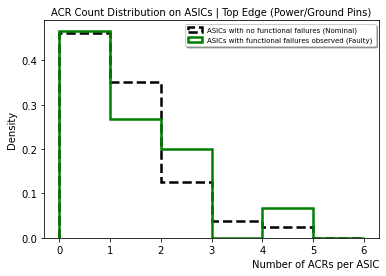

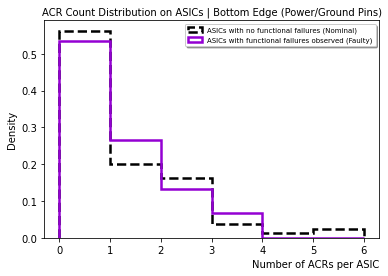

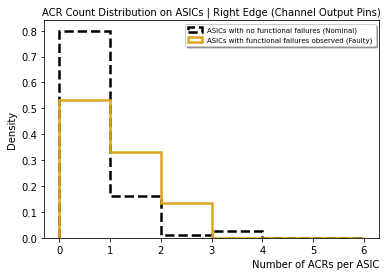

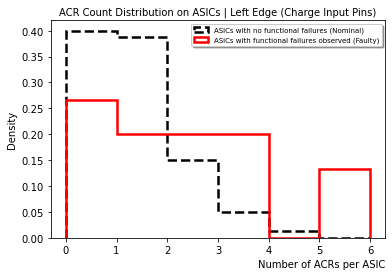

In [62]:
'''
We want to perform the same analysis (Faulty vs Nominal ACR counts) but edgewise. In the bar plots at the bottom
of this kernal it is demonstrated that the single channel failures show more ACRs on the input charge pins than the
nominal ASICs. Also below, we plot the distribution of areas edgewise for the ACRs, so we will adopt this code for this 
specific analysis.
'''

edges = [[] for i in range(0,4)]   # top = [0]  # bottom = [1]  # left = [3]  # right = [2]
for i in range(len(edges)):
    for j in range(0,2):
        edges[i].append([])   # [0] will be for Faulty, [1] will be for nominal
        
for i in range(len(edges)):
    for j in range(0,2):
        for k in range(0,100):
            edges[i][j].append([])

# edges[edge][Faulty/Nominal][ASIC]
     
# ddd_x[0] = Faulty
# ddd_x[1] = Normal


# sort the locations of the points by using the x and y _position arrays
for i in range(0,2):   # Faulty or Nominal
    for j in range(0,100):  # ASIC
        for k in range(len(ddd_x[i][j])):  # ACRs
            if ddd_x[i][j][k] != 'blank':
                # Left edge
                if ddd_x[i][j][k] < 140 and 150 < ddd_y[i][j][k] < 940:
                    edges[3][i][j].append(ddd_x[i][j][k])
                # bottom edge
                elif 200 < ddd_x[i][j][k] < 840 and 1100 < ddd_y[i][j][k]:
                    edges[1][i][j].append(ddd_x[i][j][k])
                # right edge
                elif 1000 < ddd_x[i][j][k] and 450 < ddd_y[i][j][k] < 900:
                    edges[2][i][j].append(ddd_x[i][j][k])
                # top edge
                else:
                    edges[0][i][j].append(ddd_x[i][j][k])
            else:
                edges[0][i][j].append('blank')
                edges[1][i][j].append('blank')
                edges[2][i][j].append('blank')
                edges[3][i][j].append('blank')


# Now, we can load these into a histogram bulk array and create the same plots as above (count distributions)
bad = [[] for i in range(0,4)]; good = [[] for i in range(0,4)]
# top = [0]  # bottom = [1]  # left = [3]  # right = [2]

# edges[edge][Faulty/Nominal][ASIC]

# Top Edge
for i in range(len(edges[0][0])):   # loop through all ASICs
    if len(edges[0][0][i]) == 0: 
        bad[0].append(len(edges[0][0][i]))
    else:
        if edges[0][0][i][0] != 'blank':
            bad[0].append(len(edges[0][0][i]))
for i in range(len(edges[0][1])):
    if len(edges[0][1][i]) == 0: 
        good[0].append(len(edges[0][1][i]))
    else:
        if edges[0][1][i][0] != 'blank':
            good[0].append(len(edges[0][1][i]))
            
# Bottom Edge
for i in range(len(edges[1][0])):   # loop through all ASICs
    if len(edges[1][0][i]) == 0: 
        bad[1].append(len(edges[1][0][i]))
    else:
        if edges[1][0][i][0] != 'blank':
            bad[1].append(len(edges[1][0][i]))
for i in range(len(edges[1][1])):
    if len(edges[1][1][i]) == 0: 
        good[1].append(len(edges[1][1][i]))
    else:
        if edges[1][1][i][0] != 'blank':
            good[1].append(len(edges[1][1][i]))
            
# Right Edge
for i in range(len(edges[2][0])):   # loop through all ASICs
    if len(edges[2][0][i]) == 0: 
        bad[2].append(len(edges[2][0][i]))
    else:
        if edges[2][0][i][0] != 'blank':
            bad[2].append(len(edges[2][0][i]))
for i in range(len(edges[2][1])):
    if len(edges[2][1][i]) == 0: 
        good[2].append(len(edges[2][1][i]))
    else:
        if edges[2][1][i][0] != 'blank':
            good[2].append(len(edges[2][1][i]))
            
# Left Edge
for i in range(len(edges[3][0])):   # loop through all ASICs
    if len(edges[3][0][i]) == 0: 
        bad[3].append(len(edges[3][0][i]))
    else:
        if edges[3][0][i][0] != 'blank':
            bad[3].append(len(edges[3][0][i]))
for i in range(len(edges[3][1])):
    if len(edges[3][1][i]) == 0: 
        good[3].append(len(edges[3][1][i]))
    else:
        if edges[3][1][i][0] != 'blank':
            good[3].append(len(edges[3][1][i]))
            

########## Plotting ##########

'''Top Edge'''
fig, ax = plt.subplots()
ax.set_title('ACR Count Distribution on ASICs | Top Edge (Power/Ground Pins)',fontdict = {'fontsize' : 10})
ax.set_xlabel('Number of ACRs per ASIC', loc = 'right')
ax.set_ylabel('Density')

# Plot Histograms
# maximum number of ACRs observed EDGEWISE is 5 - make the bins integer-spaced
ax.hist(good[0], bins=[0, 1, 2, 3, 4, 5, 6], label = 'ASICs with no functional failures (Nominal)', 
        histtype = 'step', linestyle = 'dashed', stacked = False, density = True, color = 'black', linewidth = 2.5)
ax.hist(bad[0], bins=[0, 1, 2, 3, 4, 5, 6], label = 'ASICs with functional failures observed (Faulty)', 
        histtype = 'step', stacked = False, density = True, color = 'green', linewidth = 2.5)

plt.legend(shadow=True, loc = 'upper right', prop={'size': 7})
path = '../../../../ACR Count Distribution for ASICs _ Top Edge.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')

plt.show()

###############
'''Bottom Edge'''
fig, ax = plt.subplots()
ax.set_title('ACR Count Distribution on ASICs | Bottom Edge (Power/Ground Pins)',fontdict = {'fontsize' : 10})
ax.set_xlabel('Number of ACRs per ASIC', loc = 'right')
ax.set_ylabel('Density')

# Plot Histograms
# maximum number of ACRs observed EDGEWISE is 5 - make the bins integer-spaced
ax.hist(good[1], bins=[0, 1, 2, 3, 4, 5, 6], label = 'ASICs with no functional failures (Nominal)', 
        histtype = 'step', linestyle = 'dashed', stacked = False, density = True, color = 'black', linewidth = 2.5)
ax.hist(bad[1], bins=[0, 1, 2, 3, 4, 5, 6], label = 'ASICs with functional failures observed (Faulty)', 
        histtype = 'step', stacked = False, density = True, color = 'darkviolet', linewidth = 2.5)

plt.legend(shadow=True, loc = 'upper right', prop={'size': 7})
path = '../../../../ACR Count Distribution for ASICs _ Bottom Edge.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')

plt.show()

###############
'''Right Edge'''
fig, ax = plt.subplots()
ax.set_title('ACR Count Distribution on ASICs | Right Edge (Channel Output Pins)',fontdict = {'fontsize' : 10})
ax.set_xlabel('Number of ACRs per ASIC', loc = 'right')
ax.set_ylabel('Density')

# Plot Histograms
# maximum number of ACRs observed EDGEWISE is 5 - make the bins integer-spaced
ax.hist(good[2], bins=[0, 1, 2, 3, 4, 5, 6], label = 'ASICs with no functional failures (Nominal)', 
        histtype = 'step', linestyle = 'dashed', stacked = False, density = True, color = 'black', linewidth = 2.5)
ax.hist(bad[2], bins=[0, 1, 2, 3, 4, 5, 6], label = 'ASICs with functional failures observed (Faulty)', 
        histtype = 'step', stacked = False, density = True, color = 'goldenrod', linewidth = 2.5)

plt.legend(shadow=True, loc = 'upper right', prop={'size': 7})
path = '../../../../ACR Count Distribution for ASICs _ Right Edge.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')

plt.show()

###############
'''Left Edge'''
fig, ax = plt.subplots()
ax.set_title('ACR Count Distribution on ASICs | Left Edge (Charge Input Pins)',fontdict = {'fontsize' : 10})
ax.set_xlabel('Number of ACRs per ASIC', loc = 'right')
ax.set_ylabel('Density')

# Plot Histograms
# maximum number of ACRs observed EDGEWISE is 5 - make the bins integer-spaced
ax.hist(good[3], bins=[0, 1, 2, 3, 4, 5, 6], label = 'ASICs with no functional failures (Nominal)', 
        histtype = 'step', linestyle = 'dashed', stacked = False, density = True, color = 'black', linewidth = 2.5)
ax.hist(bad[3], bins=[0, 1, 2, 3, 4, 5, 6], label = 'ASICs with functional failures observed (Faulty)', 
        histtype = 'step', stacked = False, density = True, color = 'red', linewidth = 2.5)

plt.legend(shadow=True, loc = 'upper right', prop={'size': 7})
path = '../../../../ACR Count Distribution for ASICs _ Left Edge.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')

plt.show()

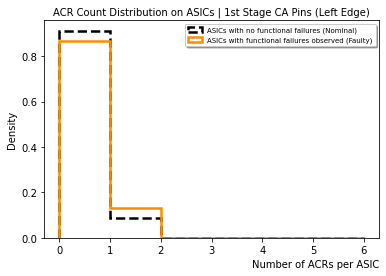

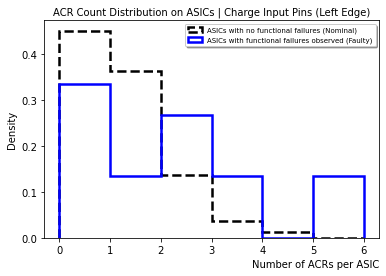

In [30]:
'''The left edge is of particular interest! There clearly is a difference between the faulty and nominal ASICs;
The faulty ASICs show a larger number of ACRs along the left edge.

In this cell, we examine further the distribution of the left edge. Namely, we look at the ACR count distributions
for the input power pins (consult ACR distribution), versus just the charge input pins.

We already have the left edge array, we can create a cut for the 1st stage of the CA and the charge input pins.
'''

# Left edge = [3rd index]

# position of the charge inputs: 
# Input -- if (1000 > data_list_y[i][j] > 230):
# CA -- other

e = [[] for i in range(0,2)]    # [0] = CA;   [1] = Input
for i in range(len(e)):
    for j in range(0,2):
        e[i].append([])
        
for i in range(len(e)):
    for j in range(0,2):
        for k in range(0,100):
            e[i][j].append([])

# sort the locations of the points by using the x and y _position arrays
for i in range(0,2):   # Faulty or Nominal
    for j in range(0,100):  # ASIC
        for k in range(len(ddd_x[i][j])):  # ACRs
            if ddd_x[i][j][k] != 'blank':
                # Left edge
                if ddd_x[i][j][k] < 140 and 150 < ddd_y[i][j][k] < 940:
                    if (1000 > ddd_y[i][j][k] > 230):
                        e[1][i][j].append(ddd_x[i][j][k])   # input pins
                    else:
                        e[0][i][j].append(ddd_x[i][j][k])   # 1st stage of CAs
            else:
                e[1][i][j].append('blank')
                e[0][i][j].append('blank')


bad_left = [[] for i in range(0,2)]; good_left = [[] for i in range(0,2)]

# CA's
for i in range(len(e[0][0])):   # loop through all ASICs
    if len(e[0][0][i]) == 0: 
        bad_left[0].append(len(e[0][0][i]))
    else:
        if e[0][0][i][0] != 'blank':
            bad_left[0].append(len(e[0][0][i]))
for i in range(len(e[0][1])):
    if len(e[0][1][i]) == 0: 
        good_left[0].append(len(e[0][1][i]))
    else:
        if e[0][1][i][0] != 'blank':
            good_left[0].append(len(e[0][1][i]))
            
# Inputs
for i in range(len(e[1][0])):   # loop through all ASICs
    if len(e[1][0][i]) == 0: 
        bad_left[1].append(len(e[1][0][i]))
    else:
        if e[1][0][i][0] != 'blank':
            bad_left[1].append(len(e[1][0][i]))
for i in range(len(e[1][1])):
    if len(e[1][1][i]) == 0: 
        good_left[1].append(len(e[1][1][i]))
    else:
        if e[1][1][i][0] != 'blank':
            good_left[1].append(len(e[1][1][i]))
            
#####################################################
# Plotting


'''Charge Amplifiers'''
fig, ax = plt.subplots()
ax.set_title('ACR Count Distribution on ASICs | 1st Stage CA Pins (Left Edge)',fontdict = {'fontsize' : 10})
ax.set_xlabel('Number of ACRs per ASIC', loc = 'right')
ax.set_ylabel('Density')

# Plot Histograms
# maximum number of ACRs observed EDGEWISE is 5 - make the bins integer-spaced
ax.hist(good_left[0], bins=[0, 1, 2, 3, 4, 5, 6], label = 'ASICs with no functional failures (Nominal)', 
        histtype = 'step', linestyle = 'dashed', stacked = False, density = True, color = 'black', linewidth = 2.5)
ax.hist(bad_left[0], bins=[0, 1, 2, 3, 4, 5, 6], label = 'ASICs with functional failures observed (Faulty)', 
        histtype = 'step', stacked = False, density = True, color = 'darkorange', linewidth = 2.5)

plt.legend(shadow=True, loc = 'upper right', prop={'size': 7})
path = 'ACR Count Distribution for ASICs _ Left Edge CAs.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')

plt.show()

###############
'''Input Pins'''
fig, ax = plt.subplots()
ax.set_title('ACR Count Distribution on ASICs | Charge Input Pins (Left Edge)',fontdict = {'fontsize' : 10})
ax.set_xlabel('Number of ACRs per ASIC', loc = 'right')
ax.set_ylabel('Density')

# Plot Histograms
# maximum number of ACRs observed EDGEWISE is 5 - make the bins integer-spaced
ax.hist(good_left[1], bins=[0, 1, 2, 3, 4, 5, 6], label = 'ASICs with no functional failures (Nominal)', 
        histtype = 'step', linestyle = 'dashed', stacked = False, density = True, color = 'black', linewidth = 2.5)
ax.hist(bad_left[1], bins=[0, 1, 2, 3, 4, 5, 6], label = 'ASICs with functional failures observed (Faulty)', 
        histtype = 'step', stacked = False, density = True, color = 'blue', linewidth = 2.5)

plt.legend(shadow=True, loc = 'upper right', prop={'size': 7})
path = 'ACR Count Distribution for ASICs _ Left Edge Inputs.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')

plt.show()

###############


### Scatterplot of ACR Distribution, but categorized based off of failure mode

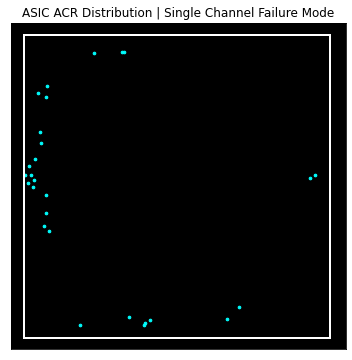

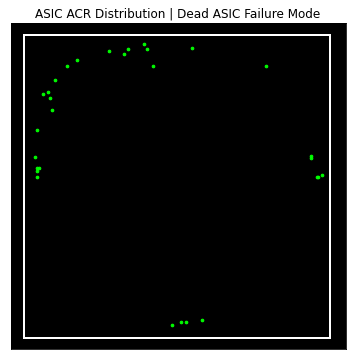

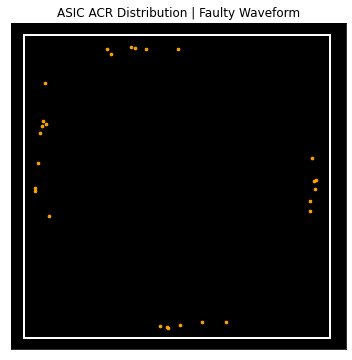

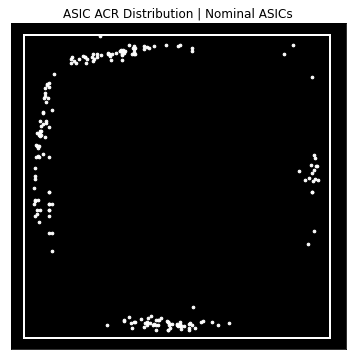

done


In [6]:
import matplotlib.pyplot as plt
import numpy as np

'''
data_x = [X_Dead, X_Single, X_Wave, X_else]
data_y = [Y_Dead, Y_Single, Y_Wave, Y_else]
'''

###############################################################
# Single Channel Failure Mode
fig, ax = plt.subplots(figsize=(6,6))
plt.xlim([-50,1220]); plt.ylim([1320,-50])

import matplotlib.patches as mpatches
left, bottom, width, height = (0, 0, 1162, 1273)  # Accurate dimensions of ASIC
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="white",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)
plt.scatter(data_x[1],data_y[1], s = 7, color = 'cyan')
plt.title('ASIC ACR Distribution | Single Channel Failure Mode')
plt.xticks([]); plt.yticks([])
ax.set_facecolor("black")
plt.savefig('ASIC ACR Distrbution Single Channel.png',dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'white')

plt.show()
###############################################################
# Dead ASIC
fig, ax = plt.subplots(figsize=(6,6))
plt.xlim([-50,1220]); plt.ylim([1320,-50])

import matplotlib.patches as mpatches
left, bottom, width, height = (0, 0, 1162, 1273)  # Accurate dimensions of ASIC
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="white",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)
plt.scatter(data_x[0],data_y[0], s = 7, color = 'lime')
plt.title('ASIC ACR Distribution | Dead ASIC Failure Mode')
plt.xticks([]); plt.yticks([])
ax.set_facecolor("black")
plt.savefig('ASIC ACR Distrbution Dead ASIC.png',dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'white')

plt.show()
###############################################################
# Faulty Waveform
fig, ax = plt.subplots(figsize=(6,6))
plt.xlim([-50,1220]); plt.ylim([1320,-50])

import matplotlib.patches as mpatches
left, bottom, width, height = (0, 0, 1162, 1273)  # Accurate dimensions of ASIC
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="white",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)
plt.scatter(data_x[2],data_y[2], s = 7, color = 'orange')
plt.title('ASIC ACR Distribution | Faulty Waveform')
plt.xticks([]); plt.yticks([])
ax.set_facecolor("black")
plt.savefig('ASIC ACR Distrbution Faulty Waveform.png',dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'white')

plt.show()
###############################################################
# All other ASICs (no specified failure mode)
fig, ax = plt.subplots(figsize=(6,6))
plt.xlim([-50,1220]); plt.ylim([1320,-50])

import matplotlib.patches as mpatches
left, bottom, width, height = (0, 0, 1162, 1273)  # Accurate dimensions of ASIC
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="white",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)
plt.scatter(data_x[3],data_y[3], s = 7, color = 'white')
plt.title('ASIC ACR Distribution | Nominal ASICs')
plt.xticks([]); plt.yticks([])
ax.set_facecolor("black")
plt.savefig('ASIC ACR Distrbution Nominal ASICs.png',dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'white')

plt.show()
###############################################################

print('done')

***
### Areas of ACRs

In [13]:
# Calculate Areas of ACRs for each 'edge'

import matplotlib.pyplot as plt
import numpy as np

# Area is the main array that has already been noise-cleaned (see above cells)
A = []   # this will be the array that has proper area units (mm^2)

# We first want to convert to some proper units (areas are given in python pixel counts)
for i in range(len(Area)):
        
        # ASIC 'pad' is 1.4cm x 1.4cm (14 mm x 14 mm)  (each SAM pixel is around 128um)
        # Total ASIC area = 1.96 cm^2 = 192 mm^2   (um too small for area) 
        # ASIC image pixel dimensions: height (y) =  1273, width (x) =  1162
        # ASIC image area = 1479226 pixels^2
        
        # Area Calculation:
        sq = Area[i]
        # unit conversion to um^2
        area_conversion = 192/1479226   # mm^2 in a square pixel
        area_ACR = area_conversion*sq
        
        A.append(round(area_ACR,5))
        
#######################################################################
# Plotting Histogram of ACR areas

fig, ax = plt.subplots()
ax.set_title('ASIC SAM ACR Areas | [0,100] Cryocycles',fontdict = {'fontsize' : 10})
ax.set_xlabel('Anti-Correlation Region Area [' + r'$mm^2$' + ']', loc = 'right')

# Plot Histograms
ax.hist(A, bins = 30, histtype = 'step', hatch = '///', stacked = False,
        color = 'navy', linewidth = 1.5)

path = 'ACR Areas.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')

plt.show()


print('done')

done


In [43]:
# Sort the ACRs into 4 distinct regions - by edges

# [0] = Top   [1] = bottom   [2] = right   [3] = left
A_edge = [[] for i in range(0,4)]

# x_position and y_position have the same dimensionality as A[]
# sort the locations of the points by using the x and y _position arrays
for i in range(len(A)):
    # Left edge
    if x_position[i] < 140 and 150 < y_position[i] < 940:
        A_edge[3].append(A[i])
    # bottom edge
    elif 200 < x_position[i] < 840 and 1100 < y_position[i]:
        A_edge[1].append(A[i])
    # right edge
    elif 1000 < x_position[i] and 450 < y_position[i] < 900:
        A_edge[2].append(A[i])
    # top edge
    else:
        A_edge[0].append(A[i])
    
#########################################################################
# Histogram of the areas of the edge ACRs
'''
### All Together ###
fig, ax = plt.subplots()
ax.set_title('ASIC SAM ACR Areas | [0,100] Cryocycles',fontdict = {'fontsize' : 10})
ax.set_xlabel('Anti-Correlation Region Area [' + r'$mm^2$' + ']', loc = 'right')

# Plot Histograms
ax.hist(A_edge[0], bins = 20, histtype = 'step', stacked = False, density = True,
        color = 'black', linewidth = 2, label = 'Top Edge')
ax.hist(A_edge[1], bins = 20, histtype = 'step', stacked = False, density = True,
        color = 'red', linewidth = 2, label = 'Bottom Edge')
ax.hist(A_edge[2], bins = 10, histtype = 'step', stacked = False, density = True,
        color = 'blue', linewidth = 2, label = 'Right Edge')
ax.hist(A_edge[3], bins = 30, histtype = 'step', stacked = False, density = True,
        color = 'green', linewidth = 2, label = 'Left Edge')

plt.legend(shadow = True, loc = 'upper right')
path = 'ACR Areas by edge.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')

plt.show()
'''

# Top Edge
fig, ax = plt.subplots()
ax.set_title('ACR Top Edge Areas | [0,100] Cryocycles',fontdict = {'fontsize' : 10})
ax.set_xlabel('Anti-Correlation Region Area [' + r'$mm^2$' + ']', loc = 'right')
# Plot Histograms
ax.hist(A_edge[0], bins = 20, histtype = 'stepfilled', stacked = False, density = True,
        color = 'goldenrod', linewidth = 2, label = 'Top Edge')
path = 'ACR Areas_top edge.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()

# Bottom Edge
fig, ax = plt.subplots()
ax.set_title('ACR Bottom Edge Areas | [0,100] Cryocycles',fontdict = {'fontsize' : 10})
ax.set_xlabel('Anti-Correlation Region Area [' + r'$mm^2$' + ']', loc = 'right')
# Plot Histograms
ax.hist(A_edge[1], bins = 20, histtype = 'stepfilled', stacked = False, density = True,
        color = 'darkorange', linewidth = 2, label = 'Top Edge')
path = 'ACR Areas_bottom edge.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()

# Right Edge
fig, ax = plt.subplots()
ax.set_title('ACR Right Edge Areas | [0,100] Cryocycles',fontdict = {'fontsize' : 10})
ax.set_xlabel('Anti-Correlation Region Area [' + r'$mm^2$' + ']', loc = 'right')
# Plot Histograms
ax.hist(A_edge[2], bins = 20, histtype = 'stepfilled', stacked = False, density = True,
        color = 'green', linewidth = 2, label = 'Top Edge')
path = 'ACR Areas_right edge.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()

# Left Edge
fig, ax = plt.subplots()
ax.set_title('ACR Left Edge Areas | [0,100] Cryocycles',fontdict = {'fontsize' : 10})
ax.set_xlabel('Anti-Correlation Region Area [' + r'$mm^2$' + ']', loc = 'right')
# Plot Histograms
ax.hist(A_edge[3], bins = 20, histtype = 'stepfilled', stacked = False, density = True,
        color = 'blue', linewidth = 2, label = 'Top Edge')
path = 'ACR Areas_left edge.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()

print('\ndone')


done


### Binning scatterpoints based off of pin type

In [7]:
# data_list_x = [x_position, X_Dead, X_Single, X_Wave, X_else]

power_pin_x = [[] for i in range(0,5)]; power_pin_y = [[] for i in range(0,5)]
CA_power_pin_x = [[] for i in range(0,5)]; CA_power_pin_y = [[] for i in range(0,5)]
input_pin_x = [[] for i in range(0,5)]; input_pin_y = [[] for i in range(0,5)]
output_pin_x = [[] for i in range(0,5)]; output_pin_y = [[] for i in range(0,5)]
ground_pin_x = [[] for i in range(0,5)]; ground_pin_y = [[] for i in range(0,5)]
other_pin_x = [[] for i in range(0,5)]; other_pin_y = [[] for i in range(0,5)]
# sanity check --> any points that fall outside of the domain of the other pins (should be zero)
junk_x = [[] for i in range(0,5)]; junk_y = [[] for i in range(0,5)]

'''
input pin location:
1000 > y > 230 while x < 130

output pin location: 
1000 > y > 230 while x > 1000

ground pin locations (not buffer):
(top)
920 > x > 305 (top, bulk) or 270 x > 220 (pin 78) x < 175 (pin 80) all while y < 150
(bottom)
x < 140 (pin 21) 245 > x > 200 (pin 23) 350 > x > 305 (pin 25) all while y > 1100

power pin locations (not buffer):
(top)
220 > x > 175 (pin 79) 300 > x > 270 (pin 77) all while y < 150
(bottom)
825 > x > 400 (bottom, bulk) 200 > x > 140 (pin 22) 305 > x > 245 (pin 24) all while y > 1100

1st stage Charge Amplifiers
(top)
230 > y while x < 130
(bottom) y > 1000 all while x < 130
'''

for i in range(len(data_list_x)):   # loop over failure modes
    for j in range(len(data_list_x[i])):  # loop over points in the failure modes
        # sort edgewise for the first if statements
        # top edge
        if data_list_y[i][j] < 150:
            # no input, output or Power for CA on top edge
            # Ground
            if (920 > data_list_x[i][j] > 305) or (270 > data_list_x[i][j] > 220) or (175 > data_list_x[i][j]):
                ground_pin_x[i].append(data_list_x[i][j]); ground_pin_y[i].append(data_list_y[i][j])
            # power
            elif (220 > data_list_x[i][j] > 175) or (300 > data_list_x[i][j] > 270):
                power_pin_x[i].append(data_list_x[i][j]); power_pin_y[i].append(data_list_y[i][j])
            # other
            else:
                other_pin_x[i].append(data_list_x[i][j]); other_pin_y[i].append(data_list_y[i][j])
        
        # bottom edge
        elif data_list_y[i][j] > 1100:
            # no input, output or Power for CA on bottom edge
            # Ground
            if (245 > data_list_x[i][j] > 200) or (350 > data_list_x[i][j] > 305) or (140 > data_list_x[i][j]):
                ground_pin_x[i].append(data_list_x[i][j]); ground_pin_y[i].append(data_list_y[i][j])
            # power
            elif (825 > data_list_x[i][j] > 400) or (200 > data_list_x[i][j] > 140) or (305 > data_list_x[i][j] > 245):
                power_pin_x[i].append(data_list_x[i][j]); power_pin_y[i].append(data_list_y[i][j])
            # other
            else:
                other_pin_x[i].append(data_list_x[i][j]); other_pin_y[i].append(data_list_y[i][j])
        
        # left edge
        elif data_list_x[i][j] < 130:
            # no ground, power, output, or other
            # Input
            if (1000 > data_list_y[i][j] > 230):
                input_pin_x[i].append(data_list_x[i][j]); input_pin_y[i].append(data_list_y[i][j])
            # Charge Amplifier
            else:
                CA_power_pin_x[i].append(data_list_x[i][j]); CA_power_pin_y[i].append(data_list_y[i][j])
                
        # right edge
        elif data_list_x[i][j] > 1000:
            # no ground, power, output, or CA
            # Ouput
            if (1000 > data_list_y[i][j] > 230):
                output_pin_x[i].append(data_list_x[i][j]); output_pin_y[i].append(data_list_y[i][j])
            # other
            else:
                other_pin_x[i].append(data_list_x[i][j]); other_pin_y[i].append(data_list_y[i][j])
                
        # all else
        else:
            junk_x[i].append(data_list_x[i][j]); junk_y[i].append(data_list_y[i][j])
            
print('done')

done


### Bar Graph displaying the number of ACRs per pin type

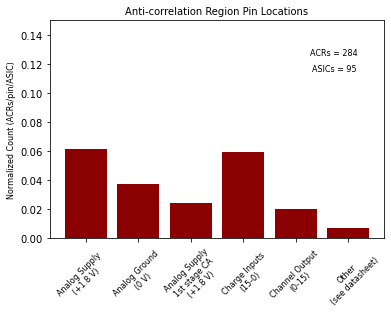

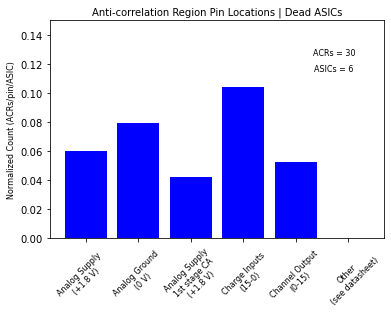

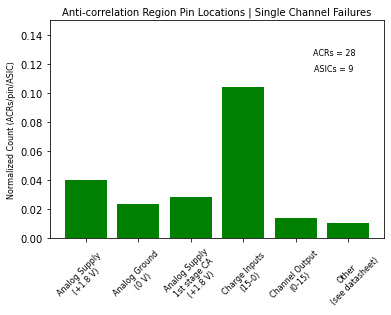

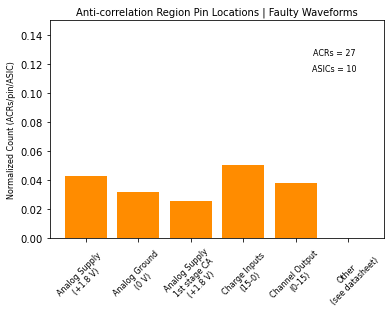

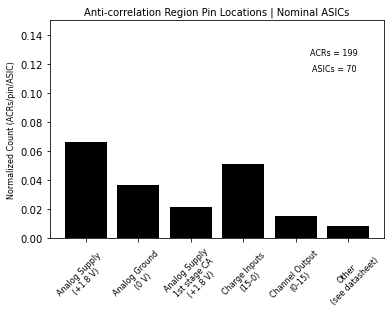

done


In [35]:
#################################################################################
'''All ASICs'''

fig, ax = plt.subplots()
ax.set_title('Anti-correlation Region Pin Locations',fontdict = {'fontsize' : 10})
#ax.set_xlabel('Pin Type', loc = 'right')
ax.set_ylabel('Normalized Count (ACRs/pin/ASIC)', fontsize = 8)

# Normalize heights of the bars
# -- Originally, we normalized by the number of pins to get ACRs/pin,
# -- however, we also want to normalize per ASIC, so ultimately we have ACRs per ASIC per pin

'''
[57, 61, 63, 90, 96]:  # remove 5 poor data ASICs
[7, 21, 55, 60, 68, 98]:   # 6 Dead ASICs
[0, 32, 33, 43, 50, 51, 68, 79, 88, 98]:  # 10 Faulty Waveform
[29, 33, 48, 54, 66, 75, 81, 91, 94]:  # 9 Single channel failures
--> Leaving (100 - 5 - 6 - 10 - 9) = 70 Nominal
(95 Total)
'''

power = (len(power_pin_x[0])/14)/95
ground = (len(ground_pin_x[0])/19)/95
CA = (len(CA_power_pin_x[0])/4)/95
inp = (len(input_pin_x[0])/16)/95
out = (len(output_pin_x[0])/16)/95
other = (len(other_pin_x[0])/11)/95

# label pin types
labels = ['Analog Supply\n(+1.8 V)', 'Analog Ground\n(0 V)', 'Analog Supply\n1st stage CA\n(+1.8 V)',
                           'Charge Inputs\n(15-0)', 'Channel Output\n(0-15)', 'Other\n(see datasheet)']
# Plot Bar Graph
ax.bar([1, 2, 3, 4, 5, 6], [power, ground, CA, inp, out, other], width = 0.8, bottom = None, align = 'center',
        color = 'darkred', linewidth = 2, label = labels)

# Label pin type for the bar xtick label
plt.text(0.10, -0.18, labels[0], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.27, -0.18, labels[1], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.43, -0.18, labels[2], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.59, -0.18, labels[3], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.74, -0.18, labels[4], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.90, -0.18, labels[5], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)

plt.text(0.85, 0.85, 'ACRs = ' + str(len(data_list_x[0])), ha='center', va='center', fontsize = 8, transform=ax.transAxes)
plt.text(0.85, 0.78, 'ASICs = 95', ha='center', va='center', fontsize = 8, transform=ax.transAxes)

# Fixed Y scaling
plt.ylim([0,0.15])

ax.set_xticklabels([])

'''
# insert image of pin overlay into corner
from matplotlib.figure import Figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

im = plt.imread('../../../../Capture.png')
im1 = OffsetImage(im, zoom =.20)
ab = AnnotationBbox(im1, (1, .5), xycoords='axes fraction', box_alignment=(1.1,-0.1))
ax.add_artist(ab)
'''

#path = 'ACR Plots/Pin Type Bar Plots/Anti Correlation Region Pin Locations _ Bar Plot.png'
path = 'ACR Plots/Pin Type Bar Plots/Anti Correlation Region Pin Locations _ Bar Plot _ Fixed Scaling.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()

#################################################################################
'''Dead ASICs'''

fig, ax = plt.subplots()
ax.set_title('Anti-correlation Region Pin Locations | Dead ASICs',fontdict = {'fontsize' : 10})
#ax.set_xlabel('Pin Type', loc = 'right')
ax.set_ylabel('Normalized Count (ACRs/pin/ASIC)', fontsize = 8)

# Normalize heights of the bars
power = (len(power_pin_x[1])/14)/6
ground = (len(ground_pin_x[1])/19)/6
CA = (len(CA_power_pin_x[1])/4)/6
inp = (len(input_pin_x[1])/16)/6
out = (len(output_pin_x[1])/16)/6
other = (len(other_pin_x[1])/11)/6

# label pin types
labels = ['Analog Supply\n(+1.8 V)', 'Analog Ground\n(0 V)', 'Analog Supply\n1st stage CA\n(+1.8 V)',
                           'Charge Inputs\n(15-0)', 'Channel Output\n(0-15)', 'Other\n(see datasheet)']
# Plot Bar Graph
ax.bar([1, 2, 3, 4, 5, 6], [power, ground, CA, inp, out, other], width = 0.8, bottom = None, align = 'center',
        color = 'blue', linewidth = 2, label = labels)

# Label pin type for the bar xtick label
plt.text(0.10, -0.18, labels[0], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.27, -0.18, labels[1], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.43, -0.18, labels[2], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.59, -0.18, labels[3], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.74, -0.18, labels[4], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.90, -0.18, labels[5], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)

plt.text(0.85, 0.85, 'ACRs = ' + str(len(data_list_x[1])), ha='center', va='center', fontsize = 8, transform=ax.transAxes)
plt.text(0.85, 0.78, 'ASICs = 6', ha='center', va='center', fontsize = 8, transform=ax.transAxes)

# Fixed Y scaling
plt.ylim([0,0.15])

ax.set_xticklabels([])

#path = 'ACR Plots/Pin Type Bar Plots/Anti Correlation Region Pin Locations _ Bar Plot _ Dead ASICs.png'
path = 'ACR Plots/Pin Type Bar Plots/Anti Correlation Region Pin Locations _ Bar Plot _ Dead ASICs _ Fixed Scaling.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()

#################################################################################
'''Single Channel ASICs'''

fig, ax = plt.subplots()
ax.set_title('Anti-correlation Region Pin Locations | Single Channel Failures',fontdict = {'fontsize' : 10})
#ax.set_xlabel('Pin Type', loc = 'right')
ax.set_ylabel('Normalized Count (ACRs/pin/ASIC)', fontsize = 8)

# Normalize heights of the bars
power = (len(power_pin_x[2])/14)/9
ground = (len(ground_pin_x[2])/19)/9
CA = (len(CA_power_pin_x[2])/4)/9
inp = (len(input_pin_x[2])/16)/9
out = (len(output_pin_x[2])/16)/9
other = (len(other_pin_x[2])/11)/9

# label pin types
labels = ['Analog Supply\n(+1.8 V)', 'Analog Ground\n(0 V)', 'Analog Supply\n1st stage CA\n(+1.8 V)',
                           'Charge Inputs\n(15-0)', 'Channel Output\n(0-15)', 'Other\n(see datasheet)']
# Plot Bar Graph
ax.bar([1, 2, 3, 4, 5, 6], [power, ground, CA, inp, out, other], width = 0.8, bottom = None, align = 'center',
        color = 'green', linewidth = 2, label = labels)

# Label pin type for the bar xtick label
plt.text(0.10, -0.18, labels[0], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.27, -0.18, labels[1], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.43, -0.18, labels[2], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.59, -0.18, labels[3], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.74, -0.18, labels[4], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.90, -0.18, labels[5], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)

plt.text(0.85, 0.85, 'ACRs = ' + str(len(data_list_x[2])), ha='center', va='center', fontsize = 8, transform=ax.transAxes)
plt.text(0.85, 0.78, 'ASICs = 9', ha='center', va='center', fontsize = 8, transform=ax.transAxes)

# Fixed Y scaling
plt.ylim([0,0.15])

ax.set_xticklabels([])

#path = 'ACR Plots/Pin Type Bar Plots/Anti Correlation Region Pin Locations _ Bar Plot _ Single Channel ASICs.png'
path = 'ACR Plots/Pin Type Bar Plots/Anti Correlation Region Pin Locations _ Bar Plot _ Single Channel ASICs _ Fixed Scaling.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()

#################################################################################
'''Faulty Waveform ASICs'''

fig, ax = plt.subplots()
ax.set_title('Anti-correlation Region Pin Locations | Faulty Waveforms',fontdict = {'fontsize' : 10})
#ax.set_xlabel('Pin Type', loc = 'right')
ax.set_ylabel('Normalized Count (ACRs/pin/ASIC)', fontsize = 8)

# Normalize heights of the bars
power = (len(power_pin_x[3])/14)/10
ground = (len(ground_pin_x[3])/19)/10
CA = (len(CA_power_pin_x[3])/4)/10
inp = (len(input_pin_x[3])/16)/10
out = (len(output_pin_x[3])/16)/10
other = (len(other_pin_x[3])/11)/10

# label pin types
labels = ['Analog Supply\n(+1.8 V)', 'Analog Ground\n(0 V)', 'Analog Supply\n1st stage CA\n(+1.8 V)',
                           'Charge Inputs\n(15-0)', 'Channel Output\n(0-15)', 'Other\n(see datasheet)']
# Plot Bar Graph
ax.bar([1, 2, 3, 4, 5, 6], [power, ground, CA, inp, out, other], width = 0.8, bottom = None, align = 'center',
        color = 'darkorange', linewidth = 2, label = labels)

# Label pin type for the bar xtick label
plt.text(0.10, -0.18, labels[0], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.27, -0.18, labels[1], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.43, -0.18, labels[2], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.59, -0.18, labels[3], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.74, -0.18, labels[4], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.90, -0.18, labels[5], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)

plt.text(0.85, 0.85, 'ACRs = ' + str(len(data_list_x[3])), ha='center', va='center', fontsize = 8, transform=ax.transAxes)
plt.text(0.85, 0.78, 'ASICs = 10', ha='center', va='center', fontsize = 8, transform=ax.transAxes)

# Fixed Y scaling
plt.ylim([0,0.15])

ax.set_xticklabels([])

#path = 'ACR Plots/Pin Type Bar Plots/Anti Correlation Region Pin Locations _ Bar Plot _ Faulty Waveforms.png'
path = 'ACR Plots/Pin Type Bar Plots/Anti Correlation Region Pin Locations _ Bar Plot _ Faulty Waveforms _ Fixed Scaling.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()

#################################################################################
'''Nominal ASICs'''

fig, ax = plt.subplots()
ax.set_title('Anti-correlation Region Pin Locations | Nominal ASICs',fontdict = {'fontsize' : 10})
#ax.set_xlabel('Pin Type', loc = 'right')
ax.set_ylabel('Normalized Count (ACRs/pin/ASIC)', fontsize = 8)

# Normalize heights of the bars
power = (len(power_pin_x[4])/14)/70
ground = (len(ground_pin_x[4])/19)/70
CA = (len(CA_power_pin_x[4])/4)/70
inp = (len(input_pin_x[4])/16)/70
out = (len(output_pin_x[4])/16)/70
other = (len(other_pin_x[4])/11)/70

# label pin types
labels = ['Analog Supply\n(+1.8 V)', 'Analog Ground\n(0 V)', 'Analog Supply\n1st stage CA\n(+1.8 V)',
                           'Charge Inputs\n(15-0)', 'Channel Output\n(0-15)', 'Other\n(see datasheet)']
# Plot Bar Graph
ax.bar([1, 2, 3, 4, 5, 6], [power, ground, CA, inp, out, other], width = 0.8, bottom = None, align = 'center',
        color = 'black', linewidth = 2, label = labels)

# Label pin type for the bar xtick label
plt.text(0.10, -0.18, labels[0], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.27, -0.18, labels[1], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.43, -0.18, labels[2], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.59, -0.18, labels[3], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.74, -0.18, labels[4], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.90, -0.18, labels[5], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)

plt.text(0.85, 0.85, 'ACRs = ' + str(len(data_list_x[4])), ha='center', va='center', fontsize = 8, transform=ax.transAxes)
plt.text(0.85, 0.78, 'ASICs = 70', ha='center', va='center', fontsize = 8, transform=ax.transAxes)

# Fixed Y scaling
plt.ylim([0,0.15])

ax.set_xticklabels([])

#path = 'ACR Plots/Pin Type Bar Plots/Anti Correlation Region Pin Locations _ Bar Plot _ Nominal ASICs.png'
path = 'ACR Plots/Pin Type Bar Plots/Anti Correlation Region Pin Locations _ Bar Plot _ Nominal ASICs _ Fixed Scaling.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()

#######################################################################################


print('done')

/var/folders/nf/wq25_wtn08vb7t3wg0hydmhr0000gr/T/ipykernel_7686/1733719034.py:49: RuntimeWarning: divide by zero encountered in double_scalars
  (((1/(np.sqrt(len(other_pin_x[1]))))*len(other_pin_x[1]))/11)/6]
/var/folders/nf/wq25_wtn08vb7t3wg0hydmhr0000gr/T/ipykernel_7686/1733719034.py:49: RuntimeWarning: invalid value encountered in double_scalars
  (((1/(np.sqrt(len(other_pin_x[1]))))*len(other_pin_x[1]))/11)/6]


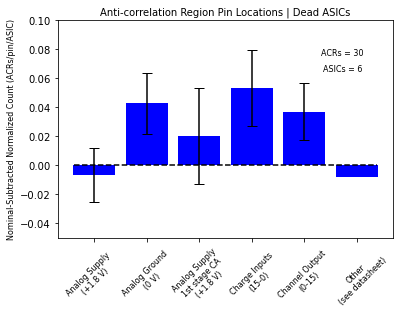

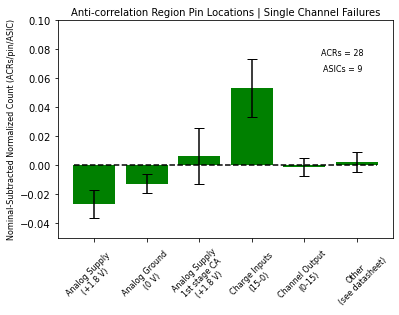

/var/folders/nf/wq25_wtn08vb7t3wg0hydmhr0000gr/T/ipykernel_7686/1733719034.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  (((1/(np.sqrt(len(other_pin_x[3]))))*len(other_pin_x[3]))/11)/10]
/var/folders/nf/wq25_wtn08vb7t3wg0hydmhr0000gr/T/ipykernel_7686/1733719034.py:177: RuntimeWarning: invalid value encountered in double_scalars
  (((1/(np.sqrt(len(other_pin_x[3]))))*len(other_pin_x[3]))/11)/10]


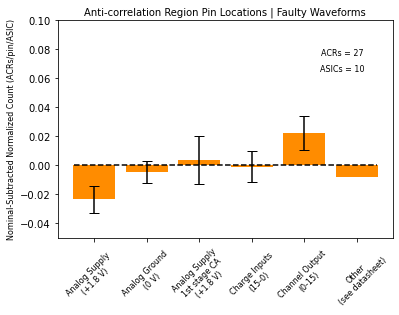

done


In [11]:
'''Normalized, Comparsion with Baseline (nominal)'''

# Background (Nominal Distribution)
BG_power = (len(power_pin_x[4])/14)/70
BG_ground = (len(ground_pin_x[4])/19)/70
BG_CA = (len(CA_power_pin_x[4])/4)/70
BG_inp = (len(input_pin_x[4])/16)/70
BG_out = (len(output_pin_x[4])/16)/70
BG_other = (len(other_pin_x[4])/11)/70

# Normalized Background errors (to be subtracted)
BG_power_er = (((1/(np.sqrt(len(power_pin_x[4]))))*len(power_pin_x[4]))/14)/70
BG_ground_er = (((1/(np.sqrt(len(ground_pin_x[4]))))*len(ground_pin_x[4]))/19)/70
BG_CA_er = (((1/(np.sqrt(len(CA_power_pin_x[4]))))*len(CA_power_pin_x[4]))/4)/70
BG_inp_er = (((1/(np.sqrt(len(input_pin_x[4]))))*len(input_pin_x[4]))/16)/70
BG_out_er = (((1/(np.sqrt(len(output_pin_x[4]))))*len(output_pin_x[4]))/16)/70
BG_other_er = (((1/(np.sqrt(len(other_pin_x[4]))))*len(other_pin_x[4]))/11)/70

BG_errors = [BG_power_er, BG_ground_er, BG_CA_er, BG_inp_er, BG_out_er, BG_other_er]

#################################################################################
'''Dead ASICs'''

fig, ax = plt.subplots()
ax.set_title('Anti-correlation Region Pin Locations | Dead ASICs',fontdict = {'fontsize' : 10})
#ax.set_xlabel('Pin Type', loc = 'right')
ax.set_ylabel('Nominal-Subtracted Normalized Count (ACRs/pin/ASIC)', fontsize = 8)

# Normalize heights of the bars
power = (len(power_pin_x[1])/14)/6 - BG_power
ground = (len(ground_pin_x[1])/19)/6 - BG_ground
CA = (len(CA_power_pin_x[1])/4)/6 - BG_CA
inp = (len(input_pin_x[1])/16)/6 - BG_inp
out = (len(output_pin_x[1])/16)/6 - BG_out
other = (len(other_pin_x[1])/11)/6 - BG_other

Dead_pins = [power, ground, CA, inp, out, other]

# Error bars
# Errors will be just statistical (1/sqrt(N)), but since the bar plots are normalized, so too do the errors.
# we will just take1/(sqrt(N)), then divide by the necessary normalization conditions. However, we also
# background subtract (Nominal), so in order to accurately convey the errors, we must subtract the nominal
# errors from the data errors.
error_Dead = [(((1/(np.sqrt(len(power_pin_x[1]))))*len(power_pin_x[1]))/14)/6,
              (((1/(np.sqrt(len(ground_pin_x[1]))))*len(ground_pin_x[1]))/19)/6, 
              (((1/(np.sqrt(len(CA_power_pin_x[1]))))*len(CA_power_pin_x[1]))/4)/6, 
              (((1/(np.sqrt(len(input_pin_x[1]))))*len(input_pin_x[1]))/16)/6, 
              (((1/(np.sqrt(len(output_pin_x[1]))))*len(output_pin_x[1]))/16)/6, 
              (((1/(np.sqrt(len(other_pin_x[1]))))*len(other_pin_x[1]))/11)/6]

for i in range(len(error_Dead)):
    if error_Dead[i] == np.inf:
        error_Dead[i] = 0.
    error_Dead[i] = np.abs(np.abs(error_Dead[i]) - np.abs(BG_errors[i]))

# label pin types
labels = ['Analog Supply\n(+1.8 V)', 'Analog Ground\n(0 V)', 'Analog Supply\n1st stage CA\n(+1.8 V)',
                           'Charge Inputs\n(15-0)', 'Channel Output\n(0-15)', 'Other\n(see datasheet)']
# Plot Bar Graph
ax.bar([1, 2, 3, 4, 5, 6], Dead_pins, yerr = error_Dead, width = 0.8, bottom = None, 
       align = 'center', color = 'blue', linewidth = 2, label = labels, capsize = 5)

# Label pin type for the bar xtick label
plt.text(0.10, -0.18, labels[0], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.27, -0.18, labels[1], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.43, -0.18, labels[2], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.59, -0.18, labels[3], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.74, -0.18, labels[4], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.90, -0.18, labels[5], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)

plt.text(0.85, 0.85, 'ACRs = ' + str(len(data_list_x[1])), ha='center', va='center', fontsize = 8, transform=ax.transAxes)
plt.text(0.85, 0.78, 'ASICs = 6', ha='center', va='center', fontsize = 8, transform=ax.transAxes)

# Fixed Y scaling
plt.ylim([-0.05,0.10])

ax.set_xticklabels([])

# Plot background level (nominal = 0)
BG_x = [0.61,1.5,2.5,3.5,4.5,5.5,6.0,6.39]; BG_y = [0,0,0,0,0,0,0,0]
plt.plot(BG_x, BG_y, color = 'black', linestyle = 'dashed')

#path = 'ACR Plots/Pin Type Bar Plots/Anti Correlation Region Pin Locations _ Bar Plot _ Dead ASICs.png'
path = 'ACR Plots/Pin Type Bar Plots/ACR Pins_ Dead ASICs _ BG Sub.png'
#path = '../../../../test.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()

#################################################################################
'''Single Channel ASICs'''

fig, ax = plt.subplots()
ax.set_title('Anti-correlation Region Pin Locations | Single Channel Failures',fontdict = {'fontsize' : 10})
#ax.set_xlabel('Pin Type', loc = 'right')
ax.set_ylabel('Nominal-Subtracted Normalized Count (ACRs/pin/ASIC)', fontsize = 8)

# Normalize heights of the bars
power = (len(power_pin_x[2])/14)/9 - BG_power
ground = (len(ground_pin_x[2])/19)/9 - BG_ground
CA = (len(CA_power_pin_x[2])/4)/9 - BG_CA
inp = (len(input_pin_x[2])/16)/9 - BG_inp
out = (len(output_pin_x[2])/16)/9 - BG_out
other = (len(other_pin_x[2])/11)/9 - BG_other

Single_pins = [power, ground, CA, inp, out, other]

# Error bars
error_Single = [(((1/(np.sqrt(len(power_pin_x[2]))))*len(power_pin_x[2]))/14)/9,
              (((1/(np.sqrt(len(ground_pin_x[2]))))*len(ground_pin_x[2]))/19)/9, 
              (((1/(np.sqrt(len(CA_power_pin_x[2]))))*len(CA_power_pin_x[2]))/4)/9, 
              (((1/(np.sqrt(len(input_pin_x[2]))))*len(input_pin_x[2]))/16)/9, 
              (((1/(np.sqrt(len(output_pin_x[2]))))*len(output_pin_x[2]))/16)/9, 
              (((1/(np.sqrt(len(other_pin_x[2]))))*len(other_pin_x[2]))/11)/9]

for i in range(len(error_Single)):
    if error_Single[i] == np.inf:
        error_Single[i] = 0.
    error_Single[i] = np.abs(np.abs(error_Single[i]) - np.abs(BG_errors[i]))
    
# label pin types
labels = ['Analog Supply\n(+1.8 V)', 'Analog Ground\n(0 V)', 'Analog Supply\n1st stage CA\n(+1.8 V)',
                           'Charge Inputs\n(15-0)', 'Channel Output\n(0-15)', 'Other\n(see datasheet)']
# Plot Bar Graph
ax.bar([1, 2, 3, 4, 5, 6], Single_pins, yerr = error_Single, width = 0.8, bottom = None,
       align = 'center', color = 'green', linewidth = 2, label = labels, capsize = 5)

# Label pin type for the bar xtick label
plt.text(0.10, -0.18, labels[0], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.27, -0.18, labels[1], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.43, -0.18, labels[2], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.59, -0.18, labels[3], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.74, -0.18, labels[4], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.90, -0.18, labels[5], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)

plt.text(0.85, 0.85, 'ACRs = ' + str(len(data_list_x[2])), ha='center', va='center', fontsize = 8, transform=ax.transAxes)
plt.text(0.85, 0.78, 'ASICs = 9', ha='center', va='center', fontsize = 8, transform=ax.transAxes)

# Fixed Y scaling
plt.ylim([-0.05,0.10])

ax.set_xticklabels([])

# Plot background level (nominal = 0)
BG_x = [0.61,1.5,2.5,3.5,4.5,5.5,6.0,6.39]; BG_y = [0,0,0,0,0,0,0,0]
plt.plot(BG_x, BG_y, color = 'black', linestyle = 'dashed')

#path = 'ACR Plots/Pin Type Bar Plots/Anti Correlation Region Pin Locations _ Bar Plot _ Single Channel ASICs.png'
path = 'ACR Plots/Pin Type Bar Plots/ACR Pins_ Single Channel Failure ASICs _ BG Sub.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()

#################################################################################

'''Faulty Waveform ASICs'''

fig, ax = plt.subplots()
ax.set_title('Anti-correlation Region Pin Locations | Faulty Waveforms',fontdict = {'fontsize' : 10})
#ax.set_xlabel('Pin Type', loc = 'right')
ax.set_ylabel('Nominal-Subtracted Normalized Count (ACRs/pin/ASIC)', fontsize = 8)

# Normalize heights of the bars
power = (len(power_pin_x[3])/14)/10 - BG_power
ground = (len(ground_pin_x[3])/19)/10 - BG_ground
CA = (len(CA_power_pin_x[3])/4)/10 - BG_CA
inp = (len(input_pin_x[3])/16)/10 - BG_inp
out = (len(output_pin_x[3])/16)/10 - BG_out
other = (len(other_pin_x[3])/11)/10 - BG_other

FW_pins = [power, ground, CA, inp, out, other]

# Error bars
error_FW = [(((1/(np.sqrt(len(power_pin_x[3]))))*len(power_pin_x[3]))/14)/10,
              (((1/(np.sqrt(len(ground_pin_x[3]))))*len(ground_pin_x[3]))/19)/10, 
              (((1/(np.sqrt(len(CA_power_pin_x[3]))))*len(CA_power_pin_x[3]))/4)/10, 
              (((1/(np.sqrt(len(input_pin_x[3]))))*len(input_pin_x[3]))/16)/10, 
              (((1/(np.sqrt(len(output_pin_x[3]))))*len(output_pin_x[3]))/16)/10, 
              (((1/(np.sqrt(len(other_pin_x[3]))))*len(other_pin_x[3]))/11)/10]

for i in range(len(error_FW)):
    if error_FW[i] == np.inf:
        error_FW[i] = 0.
    error_FW[i] = np.abs(np.abs(error_FW[i]) - np.abs(BG_errors[i]))
    

# label pin types
labels = ['Analog Supply\n(+1.8 V)', 'Analog Ground\n(0 V)', 'Analog Supply\n1st stage CA\n(+1.8 V)',
                           'Charge Inputs\n(15-0)', 'Channel Output\n(0-15)', 'Other\n(see datasheet)']
# Plot Bar Graph
ax.bar([1, 2, 3, 4, 5, 6], FW_pins, yerr = error_FW, width = 0.8, bottom = None, align = 'center',
        color = 'darkorange', linewidth = 2, label = labels, capsize = 5)

# Label pin type for the bar xtick label
plt.text(0.10, -0.18, labels[0], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.27, -0.18, labels[1], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.43, -0.18, labels[2], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.59, -0.18, labels[3], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.74, -0.18, labels[4], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.90, -0.18, labels[5], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)

plt.text(0.85, 0.85, 'ACRs = ' + str(len(data_list_x[3])), ha='center', va='center', fontsize = 8, transform=ax.transAxes)
plt.text(0.85, 0.78, 'ASICs = 10', ha='center', va='center', fontsize = 8, transform=ax.transAxes)

# Fixed Y scaling
plt.ylim([-0.05,0.10])

# Plot background level (nominal = 0)
BG_x = [0.61,1.5,2.5,3.5,4.5,5.5,6.0,6.39]; BG_y = [0,0,0,0,0,0,0,0]
plt.plot(BG_x, BG_y, color = 'black', linestyle = 'dashed')

ax.set_xticklabels([])

#path = 'ACR Plots/Pin Type Bar Plots/Anti Correlation Region Pin Locations _ Bar Plot _ Faulty Waveforms.png'
path = 'ACR Plots/Pin Type Bar Plots/ACR Pins_ Waveform Failure ASICs _ BG Sub.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()
#################################################################################

'''All Faulty ASICs'''

fig, ax = plt.subplots()
ax.set_title('Anti-correlation Region Pin Locations | Faulty ASICs',fontdict = {'fontsize' : 10})
#ax.set_xlabel('Pin Type', loc = 'right')
ax.set_ylabel('Nominal-Subtracted Normalized Count (ACRs/pin/ASIC)', fontsize = 8)

# Normalize heights of the bars
power = (len(power_pin_x[3])/14)/10 - BG_power
ground = (len(ground_pin_x[3])/19)/10 - BG_ground
CA = (len(CA_power_pin_x[3])/4)/10 - BG_CA
inp = (len(input_pin_x[3])/16)/10 - BG_inp
out = (len(output_pin_x[3])/16)/10 - BG_out
other = (len(other_pin_x[3])/11)/10 - BG_other

FW_pins = [power, ground, CA, inp, out, other]

# Error bars
error_FW = [(((1/(np.sqrt(len(power_pin_x[3]))))*len(power_pin_x[3]))/14)/10,
              (((1/(np.sqrt(len(ground_pin_x[3]))))*len(ground_pin_x[3]))/19)/10, 
              (((1/(np.sqrt(len(CA_power_pin_x[3]))))*len(CA_power_pin_x[3]))/4)/10, 
              (((1/(np.sqrt(len(input_pin_x[3]))))*len(input_pin_x[3]))/16)/10, 
              (((1/(np.sqrt(len(output_pin_x[3]))))*len(output_pin_x[3]))/16)/10, 
              (((1/(np.sqrt(len(other_pin_x[3]))))*len(other_pin_x[3]))/11)/10]

for i in range(len(error_FW)):
    if error_FW[i] == np.inf:
        error_FW[i] = 0.
    error_FW[i] = np.abs(np.abs(error_FW[i]) - np.abs(BG_errors[i]))
    

# label pin types
labels = ['Analog Supply\n(+1.8 V)', 'Analog Ground\n(0 V)', 'Analog Supply\n1st stage CA\n(+1.8 V)',
                           'Charge Inputs\n(15-0)', 'Channel Output\n(0-15)', 'Other\n(see datasheet)']
# Plot Bar Graph
ax.bar([1, 2, 3, 4, 5, 6], FW_pins, yerr = error_FW, width = 0.8, bottom = None, align = 'center',
        color = 'darkorange', linewidth = 2, label = labels, capsize = 5)

# Label pin type for the bar xtick label
plt.text(0.10, -0.18, labels[0], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.27, -0.18, labels[1], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.43, -0.18, labels[2], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.59, -0.18, labels[3], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.74, -0.18, labels[4], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)
plt.text(0.90, -0.18, labels[5], ha='center', va='center', rotation = 45, fontsize = 8, transform=ax.transAxes)

plt.text(0.85, 0.85, 'ACRs = ' + str(len(data_list_x[3])), ha='center', va='center', fontsize = 8, transform=ax.transAxes)
plt.text(0.85, 0.78, 'ASICs = 10', ha='center', va='center', fontsize = 8, transform=ax.transAxes)

# Fixed Y scaling
plt.ylim([-0.05,0.10])

# Plot background level (nominal = 0)
BG_x = [0.61,1.5,2.5,3.5,4.5,5.5,6.0,6.39]; BG_y = [0,0,0,0,0,0,0,0]
plt.plot(BG_x, BG_y, color = 'black', linestyle = 'dashed')

ax.set_xticklabels([])

#path = 'ACR Plots/Pin Type Bar Plots/Anti Correlation Region Pin Locations _ Bar Plot _ Faulty Waveforms.png'
path = 'ACR Plots/Pin Type Bar Plots/ACR Pins_ Waveform Failure ASICs _ BG Sub.png'
plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()


print('done')

In [8]:
########################################
print('(All ASICs) Total pin count:')
print('power = ', len(power_pin_x[0]))
print('ground = ', len(ground_pin_x[0]))
print('CA = ', len(CA_power_pin_x[0]))
print('input = ', len(input_pin_x[0]))
print('output = ', len(output_pin_x[0]))
print('other = ', len(other_pin_x[0]))
print('\nTotal = ', ((len(power_pin_x[0])) + (len(ground_pin_x[0])) + (len(CA_power_pin_x[0])) + (len(input_pin_x[0])) +\
      (len(output_pin_x[0])) + (len(other_pin_x[0]))))
########################################
print('#############################')
print('\n(Dead ASICs) Total pin count:')
print('power = ', len(power_pin_x[1]))
print('ground = ', len(ground_pin_x[1]))
print('CA = ', len(CA_power_pin_x[1]))
print('input = ', len(input_pin_x[1]))
print('output = ', len(output_pin_x[1]))
print('other = ', len(other_pin_x[1]))
print('\nTotal = ', ((len(power_pin_x[1])) + (len(ground_pin_x[1])) + (len(CA_power_pin_x[1])) + (len(input_pin_x[1])) +\
      (len(output_pin_x[1])) + (len(other_pin_x[1]))))
########################################
print('#############################')
print('\n(Single Channel ASICs) Total pin count:')
print('power = ', len(power_pin_x[2]))
print('ground = ', len(ground_pin_x[2]))
print('CA = ', len(CA_power_pin_x[2]))
print('input = ', len(input_pin_x[2]))
print('output = ', len(output_pin_x[2]))
print('other = ', len(other_pin_x[2]))
print('\nTotal = ', ((len(power_pin_x[2])) + (len(ground_pin_x[2])) + (len(CA_power_pin_x[2])) + (len(input_pin_x[2])) +\
      (len(output_pin_x[2])) + (len(other_pin_x[2]))))
########################################
print('#############################')
print('\n(Faulty Waveform ASICs) Total pin count:')
print('power = ', len(power_pin_x[3]))
print('ground = ', len(ground_pin_x[3]))
print('CA = ', len(CA_power_pin_x[3]))
print('input = ', len(input_pin_x[3]))
print('output = ', len(output_pin_x[3]))
print('other = ', len(other_pin_x[3]))
print('\nTotal = ', ((len(power_pin_x[3])) + (len(ground_pin_x[3])) + (len(CA_power_pin_x[3])) + (len(input_pin_x[3])) +\
      (len(output_pin_x[3])) + (len(other_pin_x[3]))))
########################################
print('#############################')
print('\n(Nominal ASICs) Total pin count:')
print('power = ', len(power_pin_x[4]))
print('ground = ', len(ground_pin_x[4]))
print('CA = ', len(CA_power_pin_x[4]))
print('input = ', len(input_pin_x[4]))
print('output = ', len(output_pin_x[4]))
print('other = ', len(other_pin_x[4]))
print('\nTotal = ', ((len(power_pin_x[4])) + (len(ground_pin_x[4])) + (len(CA_power_pin_x[4])) + (len(input_pin_x[4])) +\
      (len(output_pin_x[4])) + (len(other_pin_x[4]))))

(All ASICs) Total pin count:
power =  81
ground =  67
CA =  9
input =  90
output =  30
other =  7

Total =  284
#############################

(Dead ASICs) Total pin count:
power =  5
ground =  9
CA =  1
input =  10
output =  5
other =  0

Total =  30
#############################

(Single Channel ASICs) Total pin count:
power =  5
ground =  4
CA =  1
input =  15
output =  2
other =  1

Total =  28
#############################

(Faulty Waveform ASICs) Total pin count:
power =  6
ground =  6
CA =  1
input =  8
output =  6
other =  0

Total =  27
#############################

(Nominal ASICs) Total pin count:
power =  65
ground =  48
CA =  6
input =  57
output =  17
other =  6

Total =  199
